In [88]:
# import libs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping

In [89]:
# load dataset and check info on the columns
df=pd.read_csv('train_houses.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [90]:
# drop non-informative columns
df=df.drop(columns=['Id'],axis=1)
df=df.drop(columns=['MiscFeature'],axis=1)
df=df.drop(columns=['MiscVal'],axis=1)

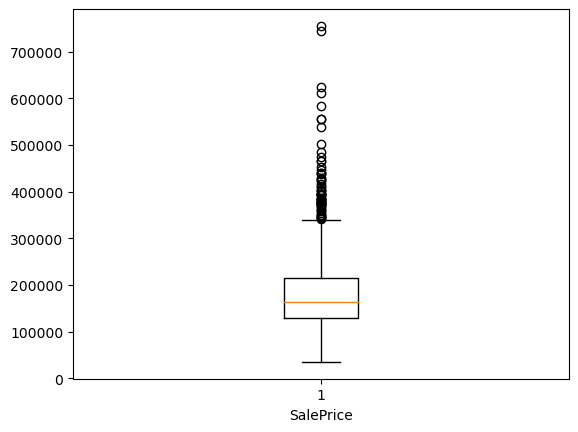

In [91]:
# describe and make a boxplot of price (y), there are outliers
# df.SalePrice.describe()
plt.boxplot(df.SalePrice)
plt.xlabel('SalePrice')
plt.show()

In [92]:
# many nans to be handled (I decided to leave the columns with many nans since they are informative and may influence the price)
df.isna().sum()

MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

In [93]:
# the list of columns with nans
cols=list(df.columns[df.isna().any()])
cols

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence']

In [94]:
# fillna with medians (for numerical data) and most frequent (for categorical data)
df['LotFrontage']=df['LotFrontage'].fillna(df['LotFrontage'].median())
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].value_counts().index[0])
df['GarageYrBlt']=df['GarageYrBlt'].fillna(df['GarageYrBlt'].median())
df['MasVnrArea']=df['MasVnrArea'].fillna(df['MasVnrArea'].median())
df['GarageYrBlt']=df['GarageYrBlt'].astype(int)
df['MasVnrArea']=df['MasVnrArea'].astype(int)
df['LotFrontage']=df['LotFrontage'].astype(int)

In [95]:
# the rest of the columns with nans are categorical and I'll group them to make the further treatment
list_cat_cols=list(df.columns[df.isna().any()])
for i in range(len(list_cat_cols)):
    df[list_cat_cols[i]]=df[list_cat_cols[i]].replace(np.nan, 'Zut')
    df[list_cat_cols[i]]=df[list_cat_cols[i]].astype('category')
    df[list_cat_cols[i]]=df[list_cat_cols[i]].cat.codes

In [96]:
# grouping the object columns to change them into categorical and then make coding to change the datatype to numerical
object_columns = list(df.select_dtypes(include=['object']).columns)
df1=df.select_dtypes(include=['object']).apply(lambda x: x.astype('category'))
df1=df1.apply(lambda x: x.cat.codes)
df.drop(columns=object_columns,axis=1,inplace=True)
df3=pd.concat([df,df1],axis=1)
df3.isna().sum()

MSSubClass       0
LotFrontage      0
LotArea          0
Alley            0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrType       0
MasVnrArea       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
PoolQC           0
Fence            0
MoSold           0
YrSold           0
SalePrice        0
MSZoning         0
Street           0
LotShape    

In [97]:
# permutation of the data and splitting into x and y
dfr=pd.DataFrame(np.random.permutation(df3.values),columns=df3.columns)
x=dfr.loc[:,df3.columns!='SalePrice']
y=dfr.loc[:,df3.columns=='SalePrice']

In [98]:
# define rmse function 
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [99]:
# train_test split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.20, random_state=1)

In [100]:
# standardize x data
scaler=StandardScaler()
scaler.fit(x)
X=scaler.transform(x)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [101]:
# tf.cast y to float32
Y=tf.cast(y, tf.float32)
Y_train=tf.cast(Y_train, tf.float32)
Y_test=tf.cast(Y_test, tf.float32)

In [102]:
# I've experimented with Sequential and Functional APIs, with different functions, and the last works better
# further I'll use the Functional APIs model with Relu function to build wide and deep neural networks
# Hidden1 layer is acting as a function where the input layer is passed on the output of the hidden1 is passed on to Hidden2
# Concat layer concatenates input layer and the output of the Hidden2 layer
# in the output layer, we have the raw input and transformed input by Hidden1&Hidden2 layers concatenated together
# because this is a regression problem, there will be only one output here
input = tf.keras.layers.Input(shape = X.shape[1:])
hidden1 = tf.keras.layers.Dense(400, activation='relu')(input)
hidden2 = tf.keras.layers.Dense(300, activation='relu')(hidden1)
concat = tf.keras.layers.Concatenate()([input, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model_final = tf.keras.models.Model(inputs=[input], outputs=[output])

In [103]:
# compilation of the model using rmse as loss, adam optimizer, and evaluation metric as rmse again
model_final.compile(
    loss=rmse,
    optimizer=Adam(),
    metrics=[rmse]
)

early_stopping=EarlyStopping(patience=50)

In [104]:
# running the model for 2000 epochs
final = model_final.fit(X_train, Y_train, epochs=2000, validation_data=(X_test, Y_test),callbacks=[early_stopping])

Epoch 1/2000
37/37 [==============================] - 1s 5ms/step - loss: 196284.5938 - rmse: 196991.2344 - val_loss: 197457.8281 - val_rmse: 195061.8281
Epoch 2/2000
37/37 [==============================] - 0s 2ms/step - loss: 195938.1562 - rmse: 195657.0625 - val_loss: 196712.2812 - val_rmse: 194339.8281
Epoch 3/2000
37/37 [==============================] - 0s 2ms/step - loss: 194070.2812 - rmse: 193655.3438 - val_loss: 194056.6406 - val_rmse: 191772.3906
Epoch 4/2000
37/37 [==============================] - 0s 2ms/step - loss: 190060.7188 - rmse: 189808.6094 - val_loss: 187790.6094 - val_rmse: 185706.2812
Epoch 5/2000
37/37 [==============================] - 0s 2ms/step - loss: 181448.2969 - rmse: 181241.7812 - val_loss: 176343.8281 - val_rmse: 174619.6250
Epoch 6/2000
37/37 [==============================] - 0s 3ms/step - loss: 167311.4688 - rmse: 167382.1719 - val_loss: 158634.3438 - val_rmse: 157487.2812
Epoch 7/2000
37/37 [==============================] - 0s 2ms/step - loss: 14

37/37 [==============================] - 0s 2ms/step - loss: 32027.1367 - rmse: 32079.2188 - val_loss: 33551.9453 - val_rmse: 33826.3945
Epoch 56/2000
37/37 [==============================] - 0s 2ms/step - loss: 31487.4648 - rmse: 31378.0059 - val_loss: 33410.7812 - val_rmse: 33705.3984
Epoch 57/2000
37/37 [==============================] - 0s 2ms/step - loss: 31300.4102 - rmse: 31131.7031 - val_loss: 33300.4648 - val_rmse: 33537.3789
Epoch 58/2000
37/37 [==============================] - 0s 2ms/step - loss: 31085.3965 - rmse: 30980.5332 - val_loss: 33042.0977 - val_rmse: 33292.4453
Epoch 59/2000
37/37 [==============================] - 0s 2ms/step - loss: 30732.2324 - rmse: 30615.1074 - val_loss: 32827.6211 - val_rmse: 33059.6680
Epoch 60/2000
37/37 [==============================] - 0s 2ms/step - loss: 30801.0234 - rmse: 30714.1582 - val_loss: 32651.3008 - val_rmse: 32841.0938
Epoch 61/2000
37/37 [==============================] - 0s 2ms/step - loss: 30713.5957 - rmse: 30677.6309 - v

37/37 [==============================] - 0s 3ms/step - loss: 24734.4668 - rmse: 24595.4648 - val_loss: 28657.0410 - val_rmse: 28241.9785
Epoch 110/2000
37/37 [==============================] - 0s 3ms/step - loss: 24701.4238 - rmse: 24509.9941 - val_loss: 28535.0918 - val_rmse: 28113.7305
Epoch 111/2000
37/37 [==============================] - 0s 3ms/step - loss: 24613.2285 - rmse: 24716.9102 - val_loss: 28609.8535 - val_rmse: 28206.4434
Epoch 112/2000
37/37 [==============================] - 0s 3ms/step - loss: 24653.8145 - rmse: 24742.8887 - val_loss: 28675.4121 - val_rmse: 28275.1562
Epoch 113/2000
37/37 [==============================] - 0s 3ms/step - loss: 23952.8906 - rmse: 24138.7871 - val_loss: 28614.2559 - val_rmse: 28204.2246
Epoch 114/2000
37/37 [==============================] - 0s 3ms/step - loss: 24484.0742 - rmse: 24422.8145 - val_loss: 28466.5977 - val_rmse: 28057.1152
Epoch 115/2000
37/37 [==============================] - 0s 2ms/step - loss: 24095.6133 - rmse: 24324.75

Epoch 163/2000
37/37 [==============================] - 0s 2ms/step - loss: 21273.3672 - rmse: 21293.3340 - val_loss: 27690.0898 - val_rmse: 27025.1777
Epoch 164/2000
37/37 [==============================] - 0s 2ms/step - loss: 21391.6777 - rmse: 21267.1406 - val_loss: 27710.1621 - val_rmse: 27088.3164
Epoch 165/2000
37/37 [==============================] - 0s 2ms/step - loss: 21248.9043 - rmse: 21145.9785 - val_loss: 27703.8281 - val_rmse: 27040.6406
Epoch 166/2000
37/37 [==============================] - 0s 2ms/step - loss: 21260.3125 - rmse: 21158.2832 - val_loss: 27675.3633 - val_rmse: 27019.8184
Epoch 167/2000
37/37 [==============================] - 0s 2ms/step - loss: 21204.3613 - rmse: 21059.4688 - val_loss: 27710.8535 - val_rmse: 27046.7617
Epoch 168/2000
37/37 [==============================] - 0s 2ms/step - loss: 21122.6191 - rmse: 21033.8945 - val_loss: 27629.8984 - val_rmse: 26954.5156
Epoch 169/2000
37/37 [==============================] - 0s 2ms/step - loss: 21010.2930 -

Epoch 217/2000
37/37 [==============================] - 0s 2ms/step - loss: 18963.8789 - rmse: 19525.8926 - val_loss: 27554.2148 - val_rmse: 26838.3535
Epoch 218/2000
37/37 [==============================] - 0s 2ms/step - loss: 19323.4590 - rmse: 19410.4004 - val_loss: 27706.2227 - val_rmse: 26969.6621
Epoch 219/2000
37/37 [==============================] - 0s 2ms/step - loss: 18925.4238 - rmse: 18787.3418 - val_loss: 27728.8320 - val_rmse: 27006.8906
Epoch 220/2000
37/37 [==============================] - 0s 2ms/step - loss: 19058.9453 - rmse: 19072.3770 - val_loss: 27702.2227 - val_rmse: 26947.5195
Epoch 221/2000
37/37 [==============================] - 0s 2ms/step - loss: 18748.3027 - rmse: 18970.5684 - val_loss: 27682.5723 - val_rmse: 26938.1992
Epoch 222/2000
37/37 [==============================] - 0s 2ms/step - loss: 18822.3398 - rmse: 18772.1387 - val_loss: 27653.0176 - val_rmse: 26910.2285
Epoch 223/2000
37/37 [==============================] - 0s 2ms/step - loss: 18781.5742 -

In [105]:
# the results of the last epoch for the test data (since the dataset is small I didn't make the additional validation split)
# rmse for the test data is significantly higher vs that of the train data - it's an overfiiting of the model
model_final.evaluate(X_test, Y_test)

10/10 [==============================] - 0s 1ms/step - loss: 27575.8340 - rmse: 26889.0586


[27575.833984375, 26889.05859375]

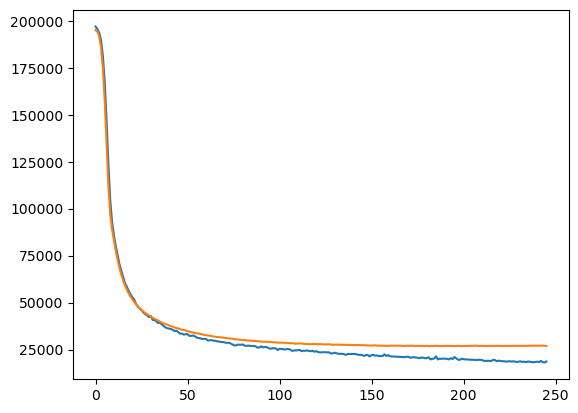

In [106]:
# plotting the history of epochs for rmse(test) and rmse(train)
plt.plot(final.history['rmse'])
plt.plot(final.history['val_rmse'])
plt.show()

In [107]:
# making predictions for all x and calculating rmse (744)
predictions=model_final.predict(X)
rmse(Y,predictions)

46/46 [==============================] - 0s 880us/step


<tf.Tensor: shape=(), dtype=float32, numpy=22623.033>

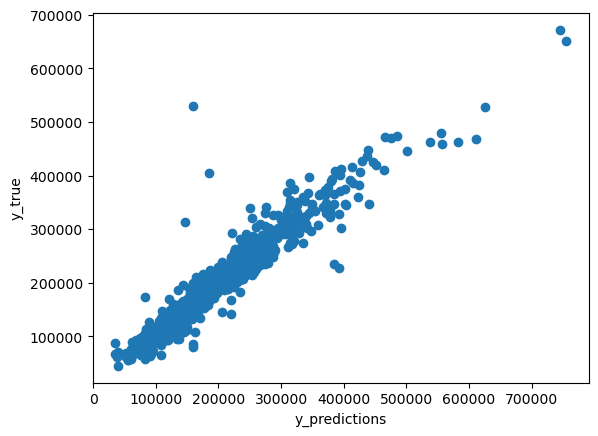

In [110]:
# plotting the final results
plt.scatter(Y,predictions)
plt.xlabel('y_predictions')
plt.ylabel('y_true')
plt.show()